In [2]:
import seaborn as sns
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
import imageio

### Figure 3B with finetuned U-Net included (goes to supplementary info)

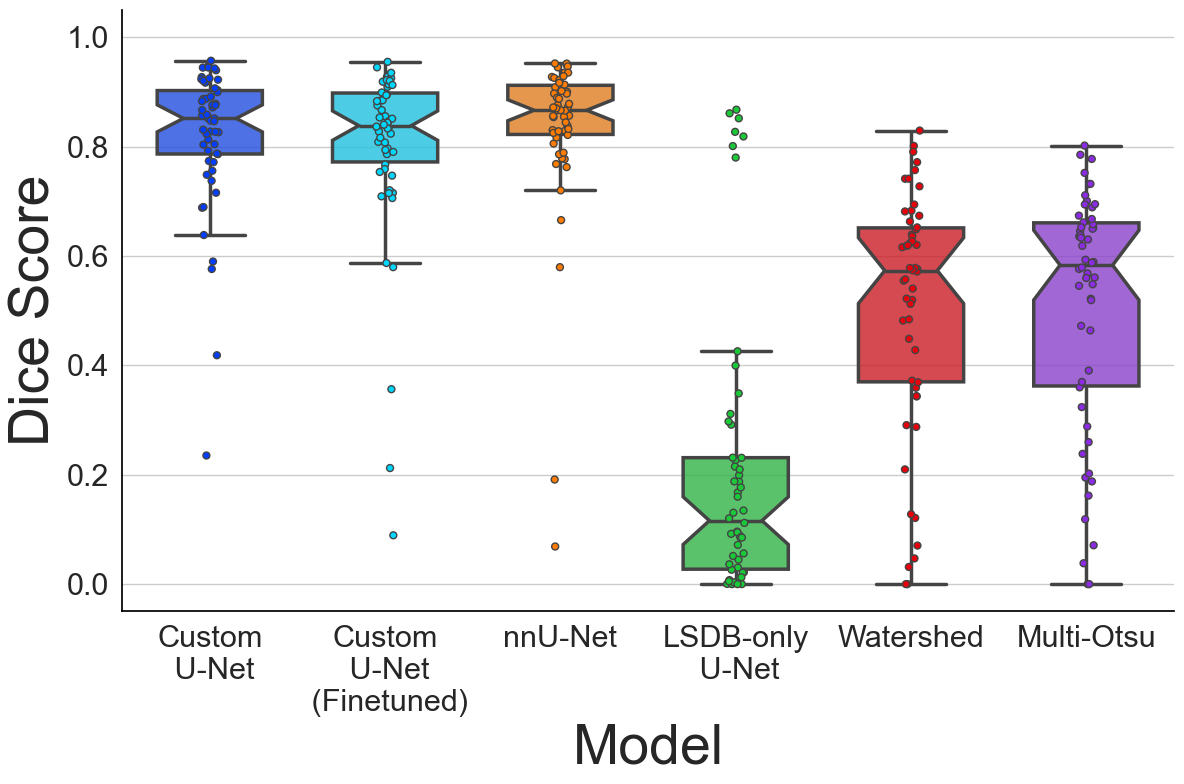

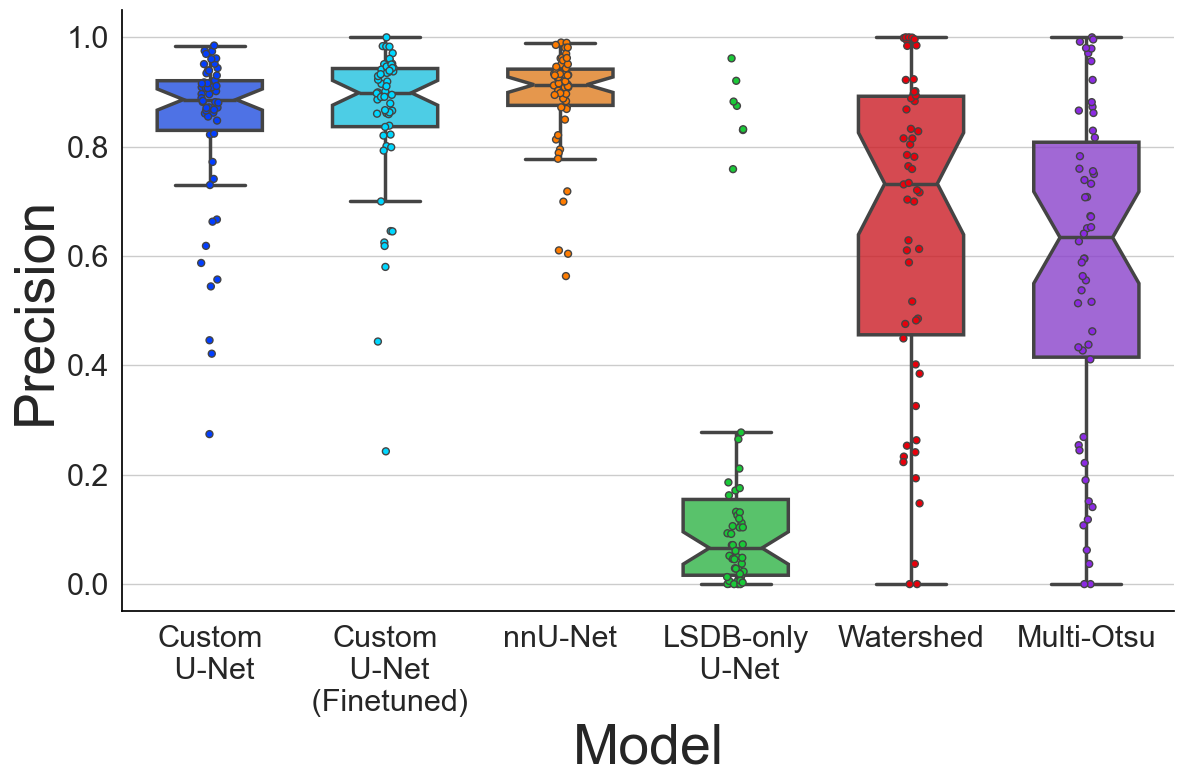

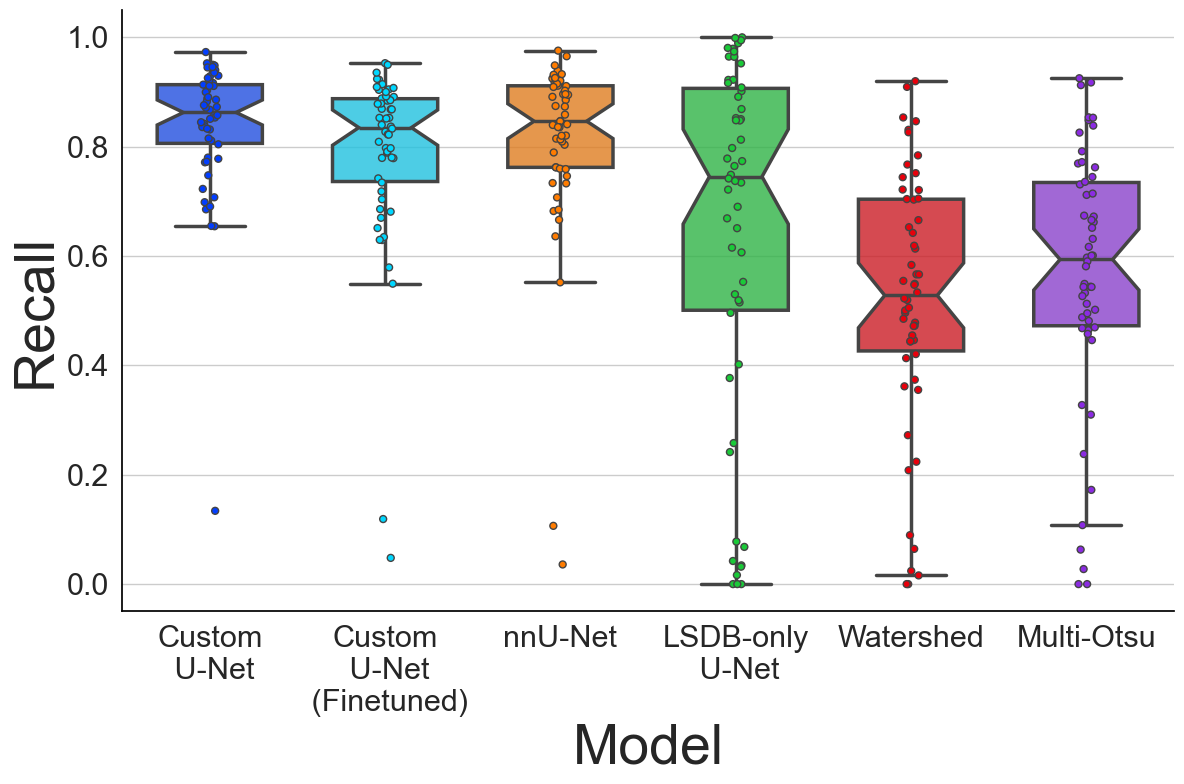

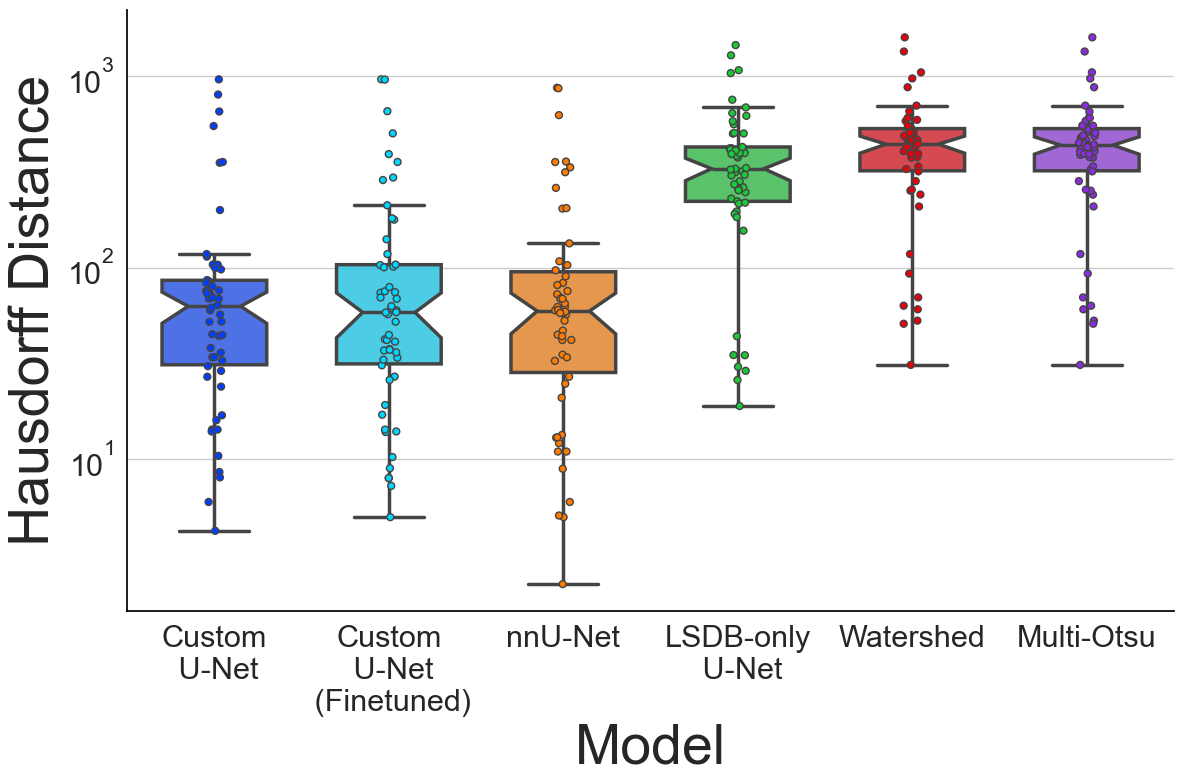

In [48]:
# fixed terms
metrics = ['Dice Score', 'MultiClass Dice Score', 'True Negatives', 'False Positives', 'False Negatives','True Positives', 'Precision', 'Recall', 'Hausdorff Distance']
data_folder = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/full_test_set_eval_extra_metrics'
output_folder = '/Users/matt/Desktop'

sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'Helvetica'
title_fontsize = 20
axis_fontsize = 40
tick_fontsize = 22
label_fontsize = 22


def plot_metric_chart(metric_of_interest, scale=None):
    # box plots for selective figures
    target_df = datasets[metric_of_interest].iloc[:, zoom_slice]
    fig, ax = plt.subplots(figsize=(12,8))

    # [x.set_linewidth(2.5) for x in ax.spines.values()]  # makes border thicker

    # Set the color of the spines to black
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    melted_df_models = pd.melt(target_df.loc[selection].reset_index(), id_vars=['Image'], var_name='model', value_name='value')

    boxplot = sns.boxplot(x='model', y='value', data=melted_df_models, showfliers=False,hue='model',legend=False,widths=[0.6],
                          notch=True, palette=sel_palette, linewidth=2.5)

    for patch in boxplot.patches:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .8))

    sns.stripplot(x='model', y='value', data=melted_df_models, jitter=0.05, legend=False, dodge=False, hue='model',
              alpha=1.0, marker="o", palette=sel_palette, linewidth=1.0)

    # plt.title('All Gels (n=54)', fontsize=title_fontsize)  # seems to overlap with figure, making tiny for now then will replace in post
    # Set font size for ticks
    boxplot.tick_params(axis='x', labelsize=tick_fontsize)
    boxplot.tick_params(axis='y', labelsize=tick_fontsize)

    # Add labels and title
    plt.xlabel('Model', fontsize=axis_fontsize)
    plt.ylabel(metric_of_interest, fontsize=axis_fontsize)

    if scale == 'log':
        ax.set_yscale('log')
    else:
        plt.yticks(tick_points, fontsize=tick_fontsize)
        ax.set_ylim(-0.05, 1.05)

    ax.set_xticks(ax.get_xticks())  # just to silence annoying warning
    boxplot.set_xticklabels(zoom_names, fontsize=label_fontsize)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f'{metric_of_interest.lower().replace(" ", "_")}_extended_test_set_boxplot.pdf'), dpi=300)
    plt.show()

# images corresponding to each dataset
dataset_titles = ['Matthew Gels 1', 'Matthew Gels 2', 'Nathan Gels', 'LSDB Gels', 'Quantitation Gels']
mg_1 = ['8', '13', '38', '62', '81', '105', '108', '114', '128', '132', '140', '143', '146', '161', '168', '179', '183',
        '187', '205', '214', '220', '230', '235', '242', '251', '257', '263', '292', '307', '312']
mg_2 = ['0', '7', '11', '32', '49', '176', '201', '216', 'mg2_214']
ng = ['UVP01944May172019', 'UVP01947May172019', 'UVP01949May172019', 'UVP02164June252019']
lsdb = ['C50-4', 'C30194', 'C51416', 'C53007', 'C60248', 'C61344', 'E864']
quantg = ['1_Thermo', '8_Thermo', '25_NEB', '29_NEB']
selection = mg_1 + mg_2 + ng + quantg + lsdb # just put in all gels from the test set

# loading and gathering datasets
datasets = {}
for m in metrics:
    datasets[m] = pd.read_csv(os.path.join(data_folder, 'metrics', m + '.csv'), index_col=0)

# custom name for each column/model
models = datasets[m].columns
custom_names = ['Old U-Net', 'Custom\n U-Net', 'Custom\n U-Net\n (Finetuned)', 'Custom U-Net\n (Extended)', 'LSDB-only\n U-Net',
                'LSDB-only U-Net\n (Extended)', 'Watershed', 'Multi-Otsu', 'nnU-Net\n (Extended)', 'nnU-Net']

# actual data for plotting
zoom_slice = [1, 2, 9, 4, 6, 7]
tick_points = [0, 0.2, 0.4, 0.6, 0.8, 1]
zoom_names = [custom_names[i] for i in zoom_slice]
zoom_columns = [models[i] for i in zoom_slice]

sns.set(style="whitegrid")
sel_palette = 'bright'
sel_palette = ['#023eff', '#00d7ff', '#ff7c00', '#1ac938', '#e8000b', '#8b2be2']
plot_metric_chart('Dice Score')
plot_metric_chart('Precision')
plot_metric_chart('Recall')
plot_metric_chart('Hausdorff Distance', scale='log')



In [91]:
# prepares data for table in supplementary material

parsed_data = []
for metric in ['Dice Score', 'Precision', 'Recall', 'Hausdorff Distance']:
    target_df = datasets[metric].iloc[:, zoom_slice].loc[selection].reset_index().replace([np.inf, -np.inf], np.nan).describe()
    for index, col in enumerate(target_df.columns):

        parsed_data.append([zoom_names[index], metric, 'mean', target_df[col]['mean']])
        parsed_data.append([zoom_names[index], metric, 'std', target_df[col]['std']])

df_parsed = pd.DataFrame(parsed_data, columns=["Model", "Metric", "Stat", "Value"])

table_df = df_parsed.pivot(index="Model", columns=["Metric", "Stat"], values="Value")


# Highlight the highest and second-highest values
def highlight_latex(column):
    col = column.copy()
    max_idx = col.idxmax()  # Index of the highest value
    second_max_idx = col[col != col[max_idx]].idxmax()  # Second-highest value
    col[max_idx] = f"\\textcolor{{red}}{{{col[max_idx]:.2f}}}"
    col[second_max_idx] = f"\\textcolor{{blue}}{{{col[second_max_idx]:.2f}}}"
    return col


# Apply formatting to all "mean" columns
highlighted_df = table_df.apply(lambda col: highlight_latex(col) if "mean" in col.name else col)
# (need to manually adjust values for Hausdorff Distance since smallest value is best)

latex_table = highlighted_df.to_latex(escape=False, float_format="%.2f")
print(latex_table)


\begin{tabular}{llrlrlrlr}
\toprule
Metric & \multicolumn{2}{r}{Dice Score} & \multicolumn{2}{r}{Precision} & \multicolumn{2}{r}{Recall} & \multicolumn{2}{r}{Hausdorff Distance} \\
Stat & mean & std & mean & std & mean & std & mean & std \\
Model &  &  &  &  &  &  &  &  \\
\midrule
Custom
 U-Net & \textcolor{blue}{0.82} & 0.13 & 0.84 & 0.15 & \textcolor{red}{0.84} & 0.13 & 118.53 & 195.13 \\
Custom
 U-Net
 (Finetuned) & 0.80 & 0.17 & \textcolor{blue}{0.86} & 0.14 & 0.79 & 0.17 & 131.59 & 208.90 \\
LSDB-only
 U-Net & 0.21 & 0.26 & 0.17 & 0.28 & 0.64 & 0.33 & 390.64 & 297.18 \\
Multi-Otsu & 0.51 & 0.22 & 0.58 & 0.30 & 0.57 & 0.24 & \textcolor{blue}{455.93} & 294.71 \\
Watershed & 0.51 & 0.22 & 0.65 & 0.30 & 0.52 & 0.24 & \textcolor{red}{456.71} & 294.74 \\
nnU-Net & \textcolor{red}{0.83} & 0.16 & \textcolor{red}{0.89} & 0.10 & \textcolor{blue}{0.81} & 0.17 & 121.17 & 188.00 \\
\bottomrule
\end{tabular}



/var/folders/bf/svk708557cgcqbh0gyt7f3gw0000gn/T/ipykernel_89591/4226266425.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textcolor{red}{0.83}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  col[max_idx] = f"\\textcolor{{red}}{{{col[max_idx]:.2f}}}"
/var/folders/bf/svk708557cgcqbh0gyt7f3gw0000gn/T/ipykernel_89591/4226266425.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textcolor{red}{0.89}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  col[max_idx] = f"\\textcolor{{red}}{{{col[max_idx]:.2f}}}"
/var/folders/bf/svk708557cgcqbh0gyt7f3gw0000gn/T/ipykernel_89591/4226266425.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textcolor{red}{0.

For gel 8, unet_dec_21 identified 100.00% of bands, with an average accuracy of 0.855
For gel 8, unet_dec_21_finetune identified 100.00% of bands, with an average accuracy of 0.845
For gel 8, nnunet_final_fold_0 identified 83.33% of bands, with an average accuracy of 0.658
For gel 8, unet_dec_21_lsdb_only identified 26.67% of bands, with an average accuracy of 0.023
For gel 8, watershed identified 20.00% of bands, with an average accuracy of 0.188
For gel 8, multiotsu identified 33.33% of bands, with an average accuracy of 0.194
----
For gel 13, unet_dec_21 identified 81.58% of bands, with an average accuracy of 0.653
For gel 13, unet_dec_21_finetune identified 78.95% of bands, with an average accuracy of 0.683
For gel 13, nnunet_final_fold_0 identified 92.11% of bands, with an average accuracy of 0.752
For gel 13, unet_dec_21_lsdb_only identified 47.37% of bands, with an average accuracy of 0.154
For gel 13, watershed identified 15.79% of bands, with an average accuracy of 0.064
For g

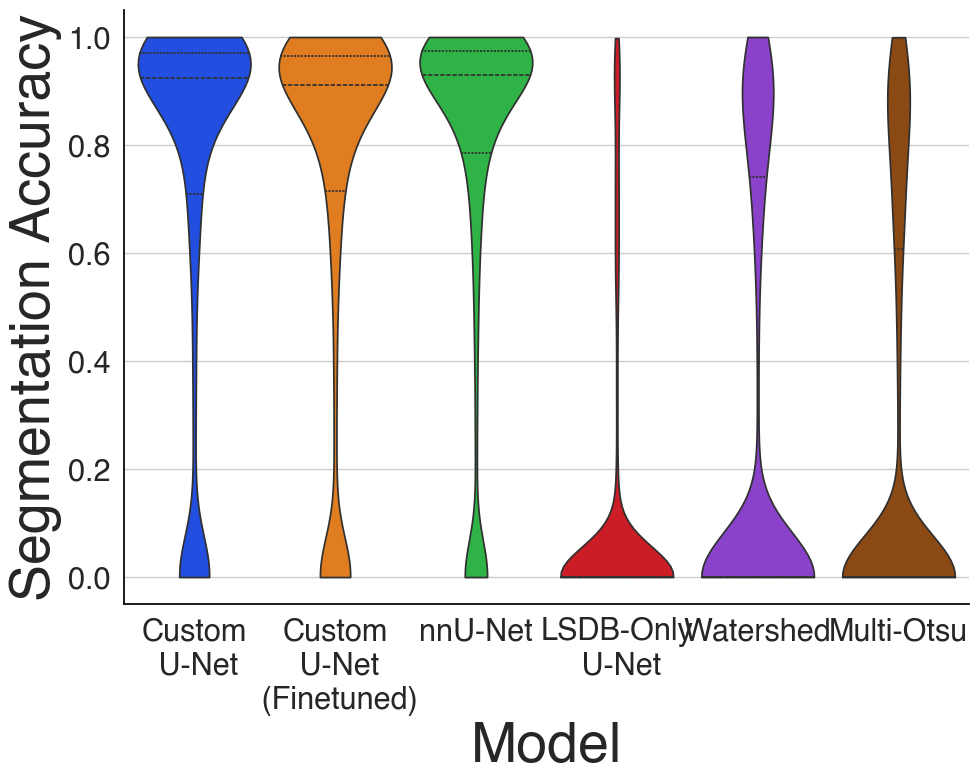

In [95]:

in_folder = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/full_test_set_eval_extra_metrics/metrics/band_level_accuracy_analysis'
eval_models = ['unet_dec_21', 'unet_dec_21_finetune', 'nnunet_final_fold_0', 'unet_dec_21_lsdb_only', 'watershed', 'multiotsu']
mg_1 = ['8', '13', '38', '62', '81', '105', '108', '114', '128', '132', '140', '143', '146', '161', '168', '179', '183',
        '187', '205', '214', '220', '230', '235', '242', '251', '257', '263', '292', '307', '312']
mg_2 = ['0', '7', '11', '32', '49', '176', '201', '216', 'mg2_214']
ng = ['UVP01944May172019', 'UVP01947May172019', 'UVP01949May172019', 'UVP02164June252019']
lsdb = ['C50-4', 'C30194', 'C51416', 'C53007', 'C60248', 'C61344', 'E864']
quantg = ['1_Thermo', '8_Thermo', '25_NEB', '29_NEB']

gel_level_dict = pickle.load(open(os.path.join(in_folder, 'gel_level_stats_no_ceiling.pkl'), 'rb'))

ceiling = False

for dataset_combo, data_name in zip([mg_1 + mg_2 + ng + quantg + lsdb], ['All Gels (n=54)']):
    model_level_accuracy_average = [0] * len(eval_models)
    model_level_id_average = [0] * len(eval_models)

    dataset_level_id_average = defaultdict(list)
    dataset_level_error_average = defaultdict(list)
    dataset_level_full_accuracy_list = defaultdict(list)

    for key, val in gel_level_dict.items():
        if key not in dataset_combo:
            continue
        for model_ind, model in enumerate(eval_models):
            id_list = val['identified'][model_ind]
            accuracy_list = [max(1 - x, 0) for x in val['error'][model_ind]]
            dataset_level_full_accuracy_list[model].extend(
                [max(1 - x, 0) if val['multi_band'][model_ind][ind] is False else 0 for ind, x in enumerate(val['error'][model_ind])])
            if sum(id_list) == 0:
                percent_identified = 0
                average_accuracy_for_identified = 0
            else:
                percent_identified = (sum(id_list) / len(id_list)) * 100
                if ceiling:
                    average_accuracy_for_identified = sum([err for id, err in zip(id_list, accuracy_list) if id]) / sum(
                        id_list)
                else:
                    average_accuracy_for_identified = sum(accuracy_list) / len(accuracy_list)

            print(f'For gel {key}, {model} identified {percent_identified:.2f}% of bands, with an average accuracy of {average_accuracy_for_identified:.3f}')
            model_level_id_average[model_ind] += percent_identified
            model_level_accuracy_average[model_ind] += average_accuracy_for_identified
            dataset_level_id_average[model].append(percent_identified)
            dataset_level_error_average[model].append(average_accuracy_for_identified)
        print('----')
    print('---------')

    model_level_accuracy_average = [x / len(dataset_combo) for x in model_level_accuracy_average]
    model_level_id_average = [x / len(dataset_combo) for x in model_level_id_average]

    print('Final averages:')
    print(model_level_accuracy_average)
    print(model_level_id_average)

    id_dataset = pd.DataFrame.from_dict(dataset_level_id_average)
    accuracy_dataset = pd.DataFrame.from_dict(dataset_level_error_average)

    full_accuracy_dataset = pd.DataFrame.from_dict(dataset_level_full_accuracy_list)
    full_accuracy_dataset.rename(columns={'unet_dec_21': 'Custom\n U-Net',
                                          'unet_dec_21_finetune': 'Custom\n U-Net\n (Finetuned)',
                                          'nnunet_final_fold_0': 'nnU-Net',
                                          'unet_dec_21_lsdb_only': 'LSDB-Only\n U-Net',
                                          'watershed': 'Watershed',
                                          'multiotsu': 'Multi-Otsu'}, inplace=True)

    sns.set(style="whitegrid")
    plt.rcParams['font.family'] = 'Helvetica'

    fig, ax = plt.subplots(figsize=(10, 8))

    vplot = sns.violinplot(data=full_accuracy_dataset, cut=0,
                           palette='bright', inner='quartile')

    # Set the color of the spines to black
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.ylabel('Segmentation Accuracy', fontsize=40)
    plt.xlabel('Model', fontsize=40)
    plt.yticks(fontsize=22)
    vplot.tick_params(axis='x', labelsize=22)
    plt.tight_layout()
    # plt.savefig('/Users/matt/Desktop/full_gel_level_accuracy_violin.pdf')
    plt.show()


In [97]:
# this table is used to populate the supplementary material table
full_accuracy_dataset.describe()

,Custom\n U-Net,Custom\n U-Net\n (Finetuned),nnU-Net,LSDB-Only\n U-Net,Watershed,Multi-Otsu
count,2622.000000,2622.000000,2622.000000,2622.000000,2622.000000,2622.000000
mean,0.744760,0.742350,0.782868,0.102984,0.265042,0.231742
std,0.352393,0.346309,0.318799,0.257817,0.394572,0.367468
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.708803,0.714236,0.785777,0.000000,0.000000,0.000000
50%,0.923541,0.911629,0.929850,0.000000,0.000000,0.000000
75%,0.969846,0.965384,0.973595,0.000000,0.740479,0.607131
max,0.999981,0.999965,0.999993,0.997984,1.000000,0.999550


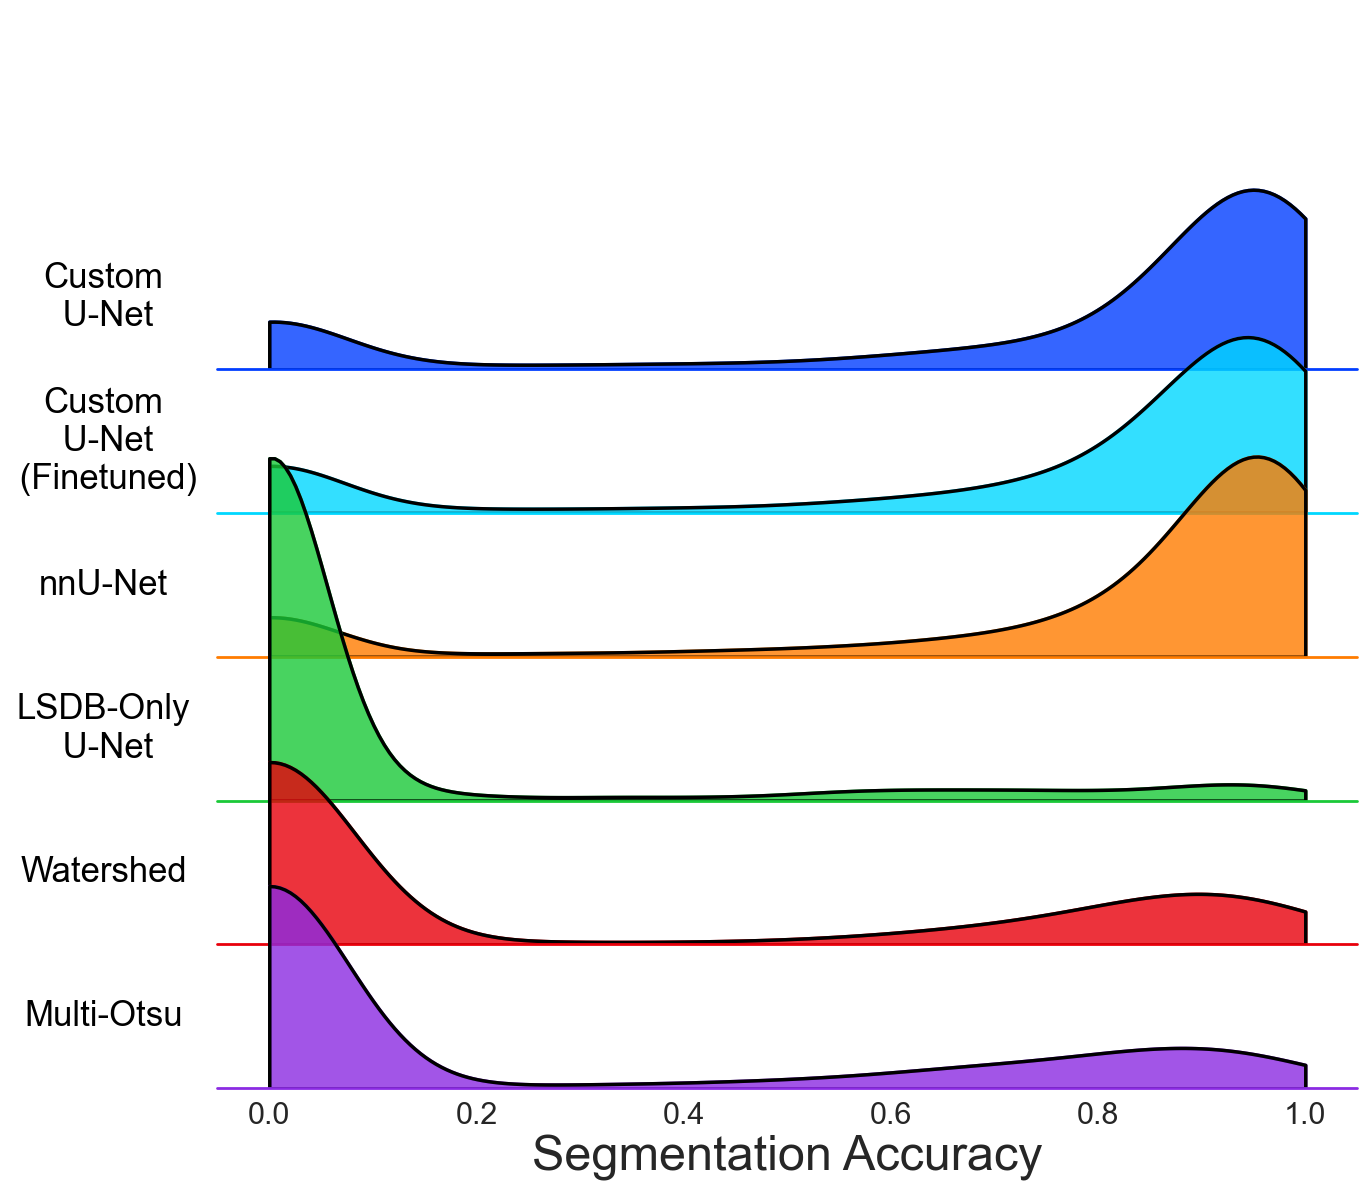

In [102]:
# version 3 of Fig. 3C
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
palette = 'bright'
palette = ['#023eff', '#00d7ff', '#ff7c00', '#1ac938', '#e8000b', '#8b2be2']

g = sns.FacetGrid(pd.melt(full_accuracy_dataset), row= 'variable', hue='variable', palette=palette, aspect=7, height=2)

# Draw the densities in a few steps
g.map(sns.kdeplot, "value", clip=(0,1), fill=True, alpha=0.8, linewidth=2.5)
g.map(sns.kdeplot, "value", clip=(0,1), fill=True, alpha=0, color="black", linewidth=2.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.1, .2, label, color='black', fontsize=25,
            ha="center", va="center", transform=ax.transAxes)

g.map(label, "value")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.6)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True, right=True, top=True)
plt.xlabel('Segmentation Accuracy', fontsize=35)
plt.xticks(fontsize=22)

# plt.tight_layout()
plt.savefig('/Users/matt/Desktop/ridge_plot_with_finetuned_model.pdf', bbox_inches='tight')

### New Figures/Tables that test models on a completely blind external dataset of 25 images

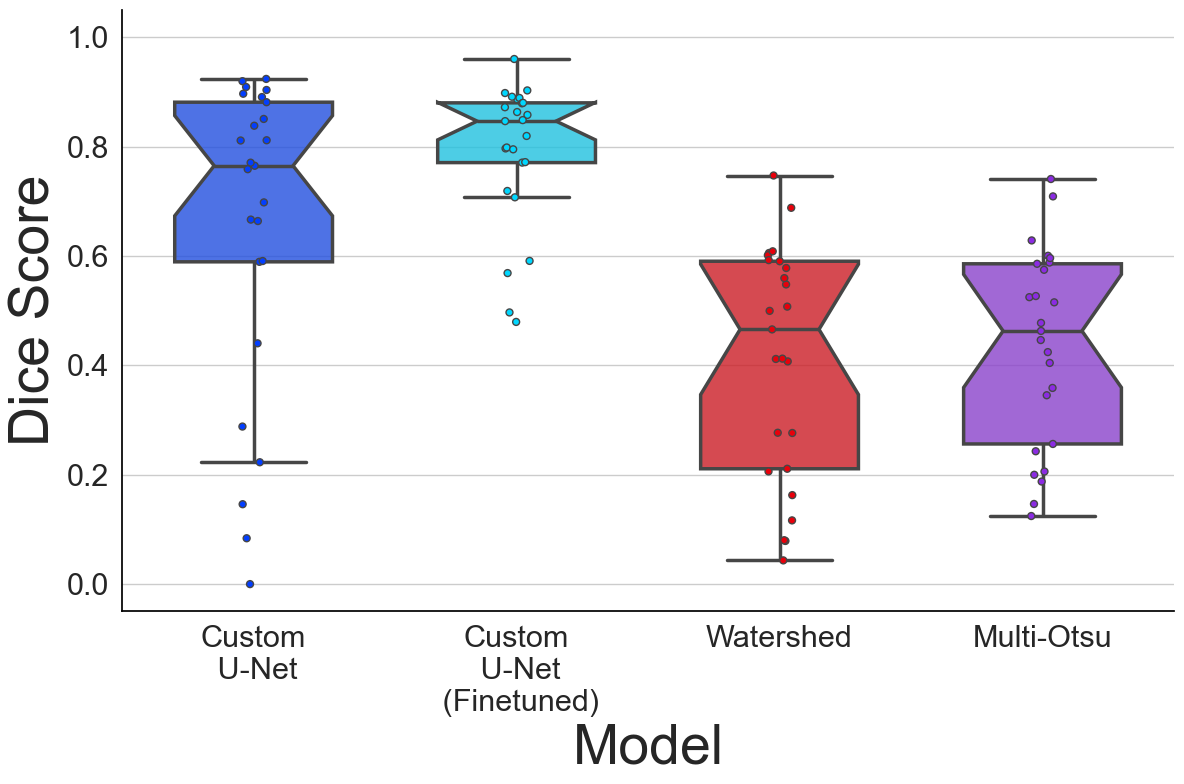

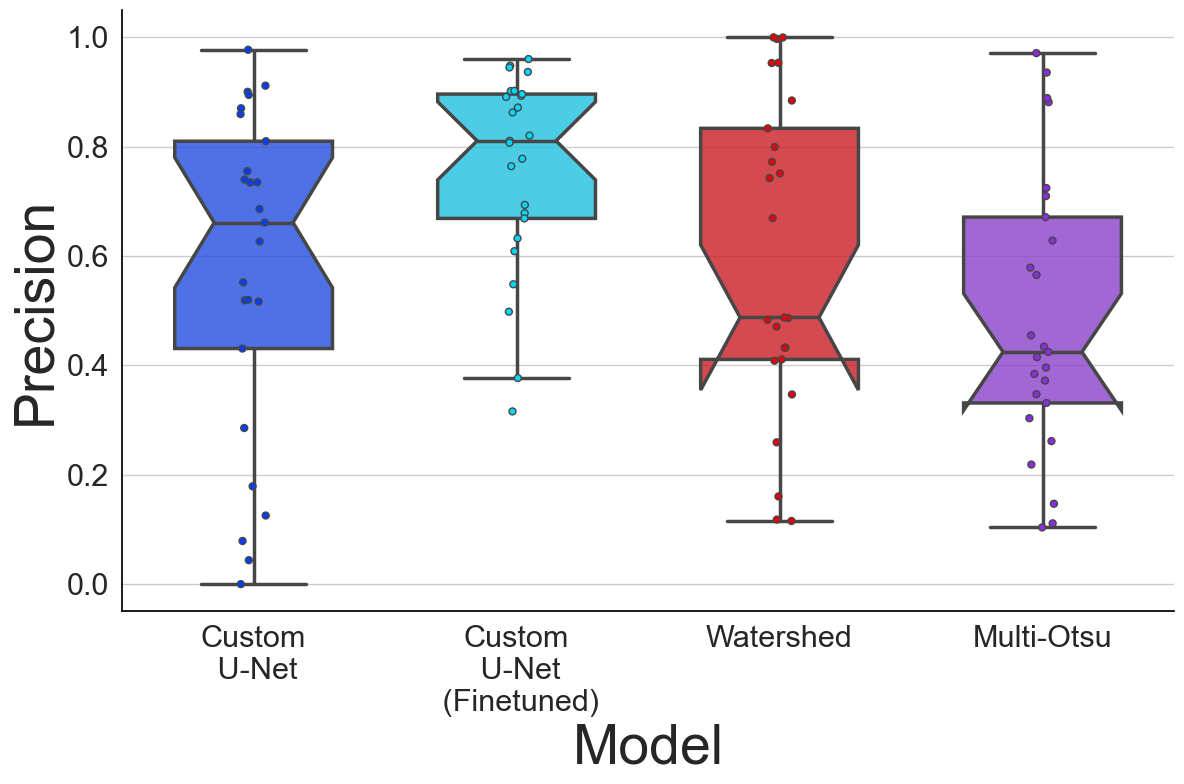

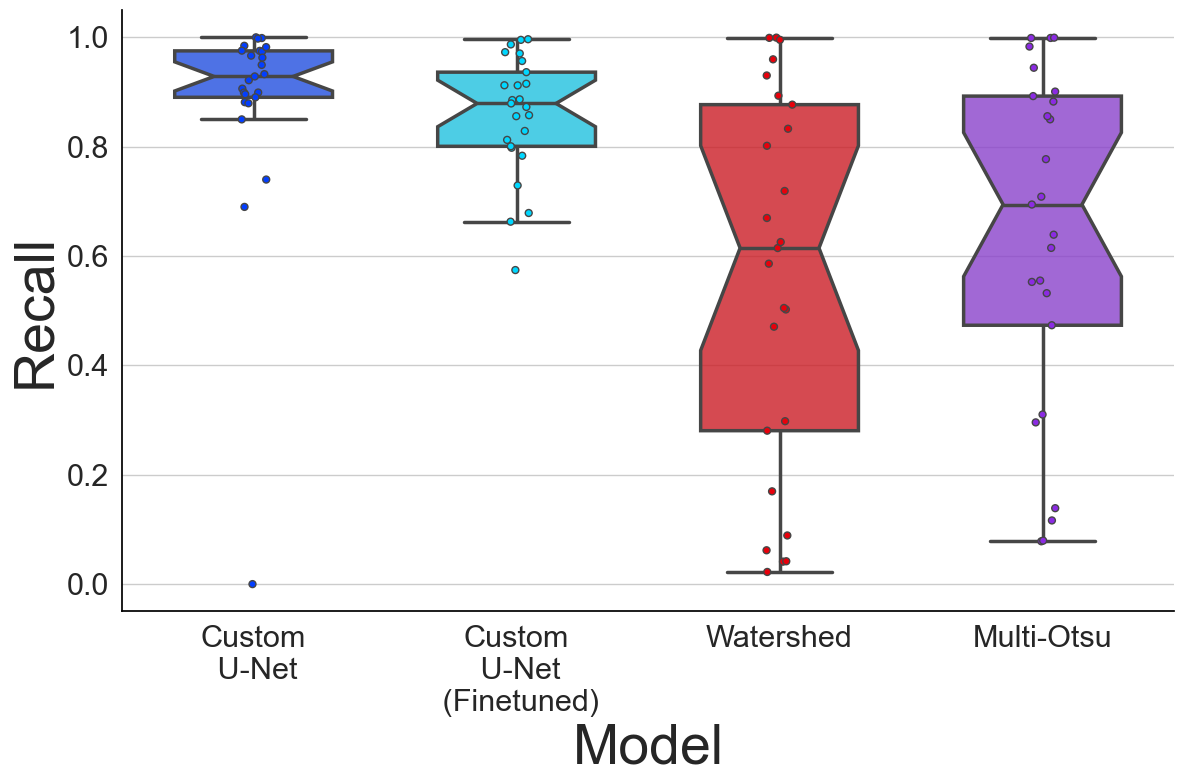

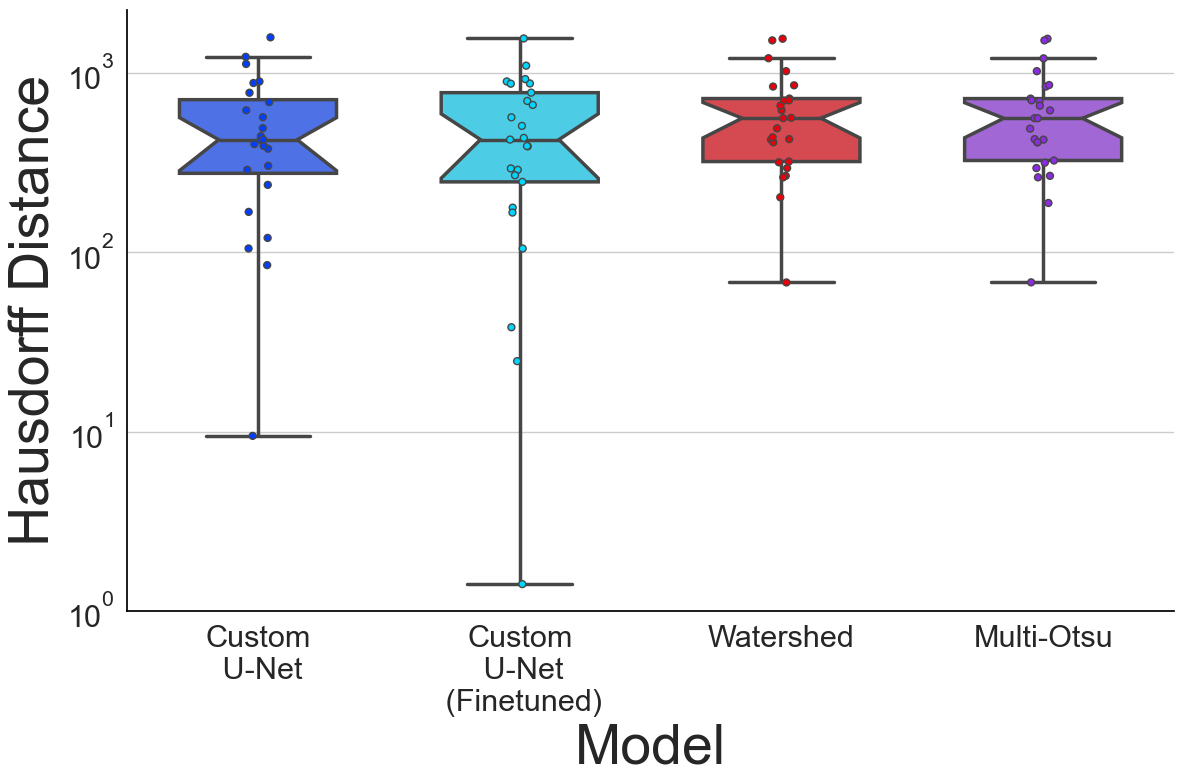

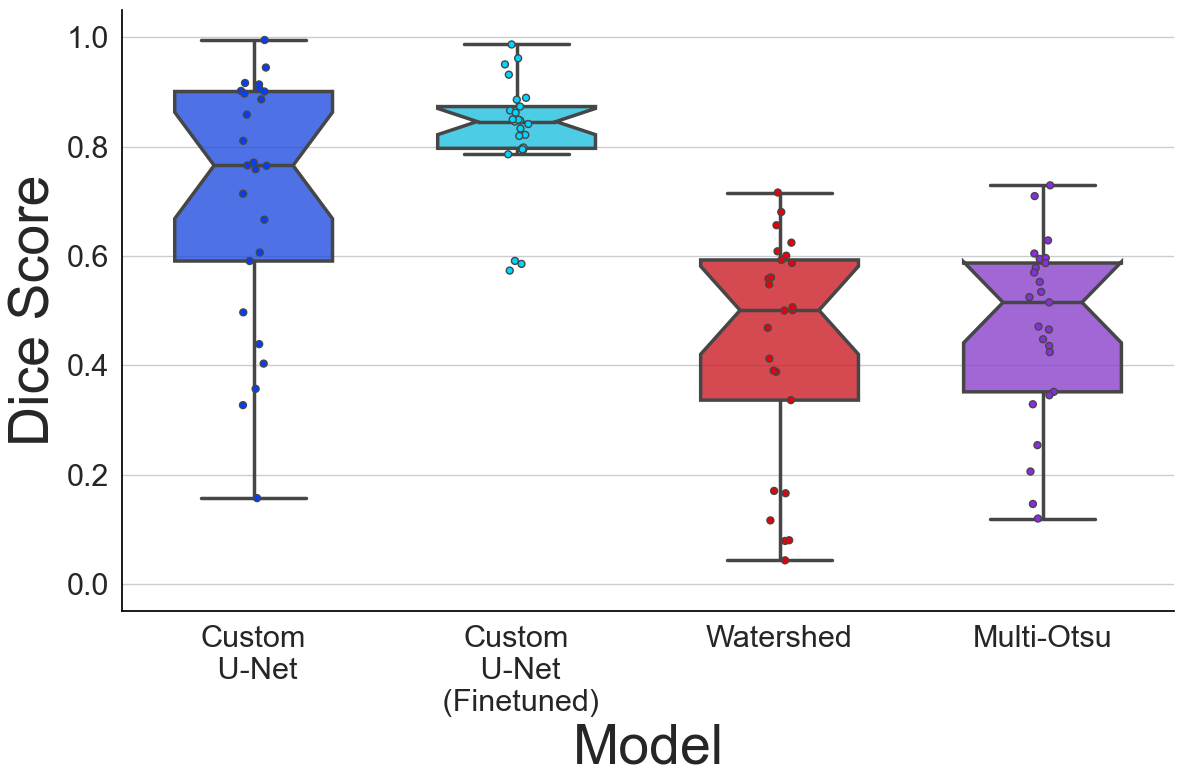

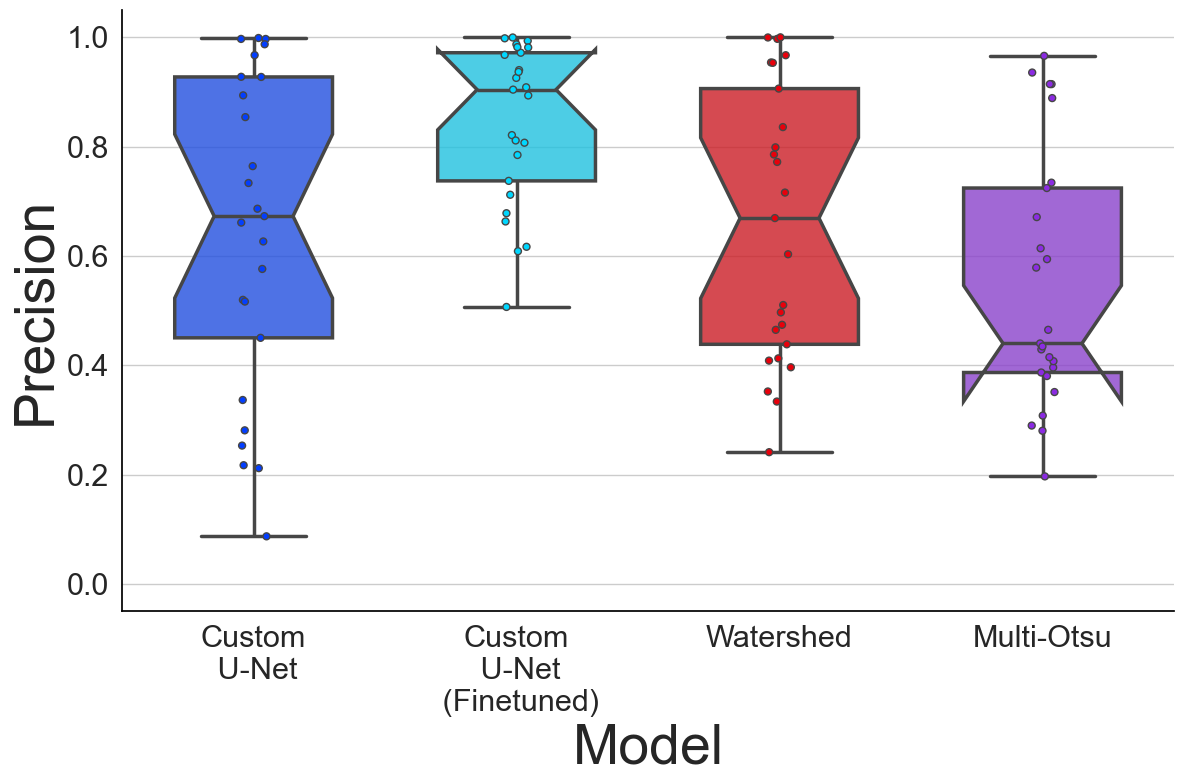

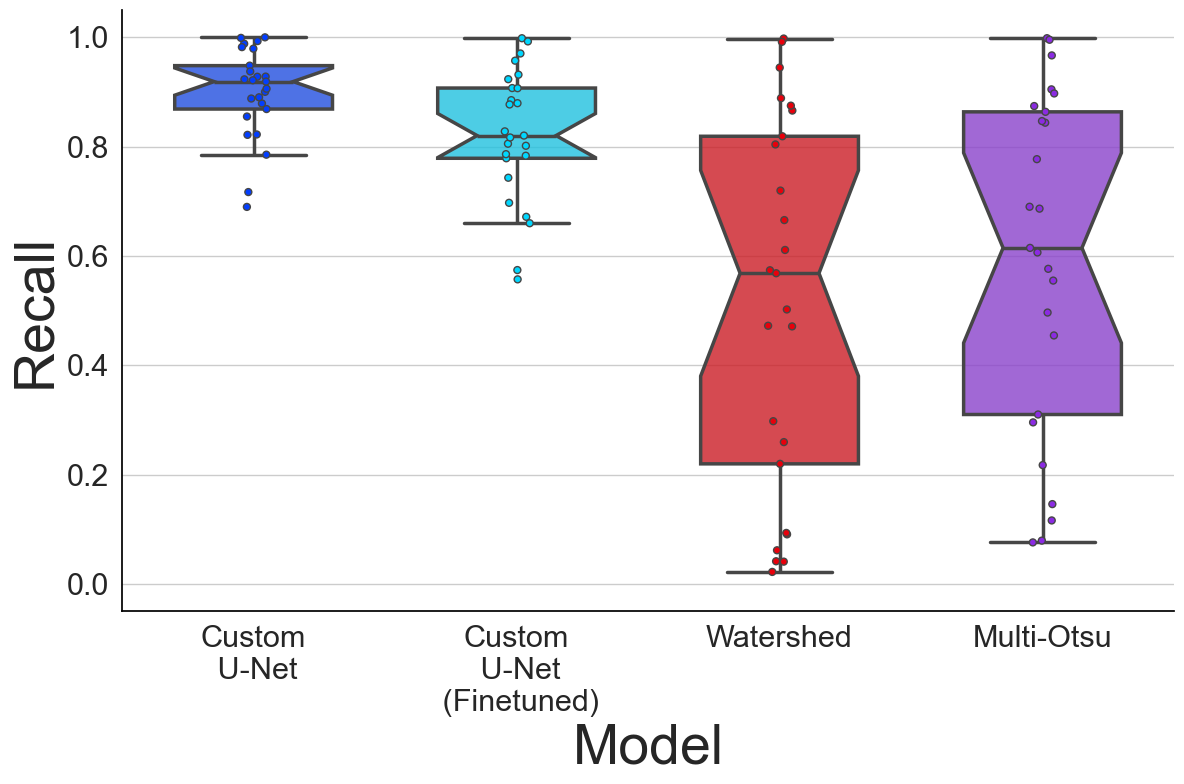

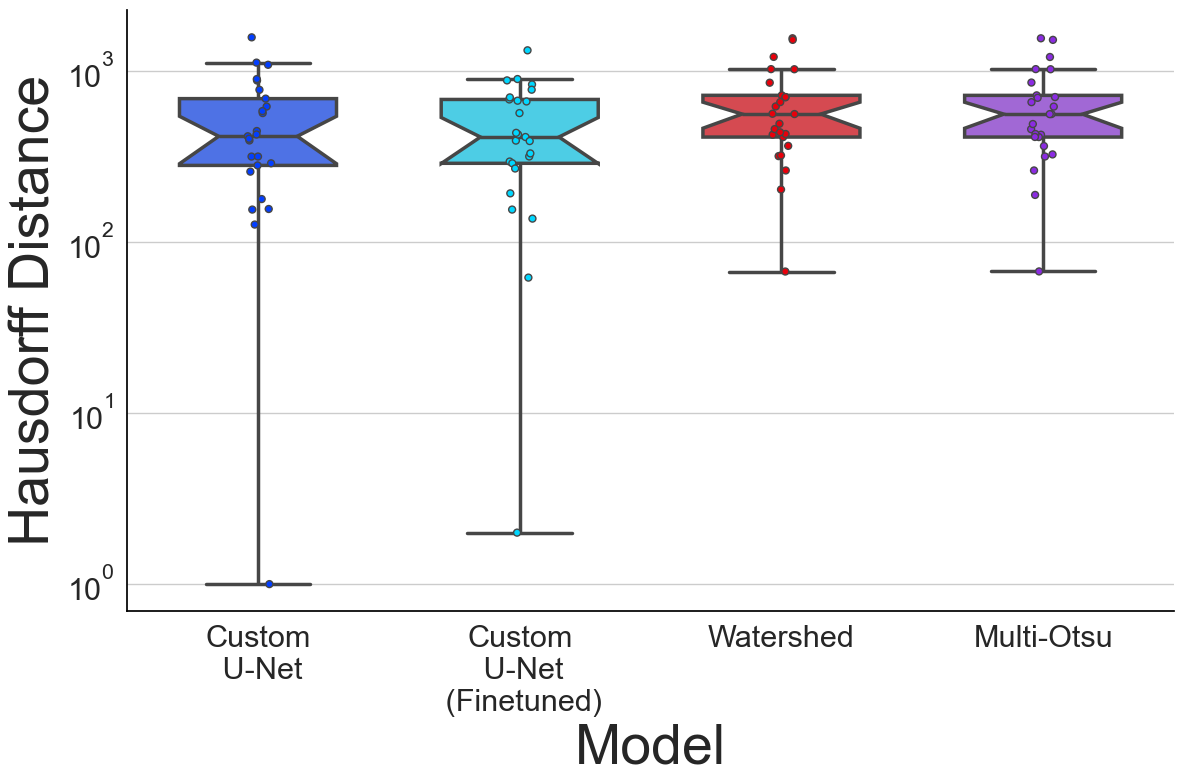

In [112]:
# fixed terms
metrics = ['Dice Score', 'MultiClass Dice Score', 'True Negatives', 'False Positives', 'False Negatives','True Positives', 'Precision', 'Recall', 'Hausdorff Distance']
data_folder = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/external_test_set_eval/external_eval_standard'
data_folder_percentile = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/external_test_set_eval/external_eval_percentile_norm'

output_folder = '/Users/matt/Desktop'

sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'Helvetica'
title_fontsize = 20
axis_fontsize = 40
tick_fontsize = 22
label_fontsize = 22


def plot_metric_chart(metric_of_interest, data_source, data_name, scale=None):
    # box plots for selective figures
    target_df = data_source[metric_of_interest].iloc[:, zoom_slice]
    fig, ax = plt.subplots(figsize=(12,8))

    # Set the color of the spines to black
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    melted_df_models = pd.melt(target_df.reset_index(), id_vars=['Image'], var_name='model', value_name='value')

    boxplot = sns.boxplot(x='model', y='value', data=melted_df_models, showfliers=False,hue='model',legend=False,widths=[0.6],
                          notch=True, palette=sel_palette, linewidth=2.5)

    for patch in boxplot.patches:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .8))

    sns.stripplot(x='model', y='value', data=melted_df_models, jitter=0.05, legend=False, dodge=False, hue='model',
              alpha=1.0, marker="o", palette=sel_palette, linewidth=1.0)

    # plt.title('All Gels (n=54)', fontsize=title_fontsize)  # seems to overlap with figure, making tiny for now then will replace in post
    # Set font size for ticks
    boxplot.tick_params(axis='x', labelsize=tick_fontsize)
    boxplot.tick_params(axis='y', labelsize=tick_fontsize)

    # Add labels and title
    plt.xlabel('Model', fontsize=axis_fontsize)
    plt.ylabel(metric_of_interest, fontsize=axis_fontsize)

    if scale == 'log':
        ax.set_yscale('log')
    else:
        plt.yticks(tick_points, fontsize=tick_fontsize)
        ax.set_ylim(-0.05, 1.05)

    ax.set_xticks(ax.get_xticks())  # just to silence annoying warning
    boxplot.set_xticklabels(zoom_names, fontsize=label_fontsize)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f'{metric_of_interest.lower().replace(" ", "_")}_external_{data_name}_boxplot.pdf'), dpi=300)
    plt.show()

# loading and gathering datasets
datasets = {}
datasets_percentile = {}
for m in metrics:
    datasets[m] = pd.read_csv(os.path.join(data_folder, 'metrics', m + '.csv'), index_col=0)
    datasets[m] = datasets[m].drop(index='mean')
    datasets_percentile[m] = pd.read_csv(os.path.join(data_folder_percentile, 'metrics', m + '.csv'), index_col=0)
    datasets_percentile[m] = datasets_percentile[m].drop(index='mean')

# custom name for each column/model
models = datasets[m].columns
custom_names = ['Custom\n U-Net', 'Custom\n U-Net\n (Finetuned)', 'Watershed', 'Multi-Otsu']

# actual data for plotting
zoom_slice = [0, 1, 2, 3]
tick_points = [0, 0.2, 0.4, 0.6, 0.8, 1]
zoom_names = [custom_names[i] for i in zoom_slice]
zoom_columns = [models[i] for i in zoom_slice]

sns.set(style="whitegrid")
sel_palette = 'bright'
sel_palette = ['#023eff', '#00d7ff', '#e8000b', '#8b2be2']
plot_metric_chart('Dice Score', datasets, 'standard')
plot_metric_chart('Precision', datasets, 'standard')
plot_metric_chart('Recall', datasets, 'standard')
plot_metric_chart('Hausdorff Distance', datasets, 'standard', scale='log')

plot_metric_chart('Dice Score', datasets_percentile, 'percentile')
plot_metric_chart('Precision', datasets_percentile, 'percentile')
plot_metric_chart('Recall', datasets_percentile, 'percentile')
plot_metric_chart('Hausdorff Distance', datasets_percentile, 'percentile', scale='log')


In [115]:

# prepares data for table in supplementary material

parsed_data = []
parsed_percentile_data = []
for metric in ['Dice Score', 'Precision', 'Recall', 'Hausdorff Distance']:
    target_df = datasets[metric].iloc[:, zoom_slice].reset_index().replace([np.inf, -np.inf], np.nan).describe()
    target_df_percentile = datasets_percentile[metric].iloc[:, zoom_slice].reset_index().replace([np.inf, -np.inf], np.nan).describe()
    for index, col in enumerate(target_df.columns):
        parsed_data.append([zoom_names[index], metric, 'mean', target_df[col]['mean']])
        parsed_data.append([zoom_names[index], metric, 'std', target_df[col]['std']])
        parsed_percentile_data.append([zoom_names[index], metric, 'mean', target_df_percentile[col]['mean']])
        parsed_percentile_data.append([zoom_names[index], metric, 'std', target_df_percentile[col]['std']])

df_parsed = pd.DataFrame(parsed_data, columns=["Model", "Metric", "Stat", "Value"])
df_parsed_percentile = pd.DataFrame(parsed_percentile_data, columns=["Model", "Metric", "Stat", "Value"])

table_df = df_parsed.pivot(index="Model", columns=["Metric", "Stat"], values="Value")
table_df_percentile = df_parsed_percentile.pivot(index="Model", columns=["Metric", "Stat"], values="Value")

# Highlight the highest and second-highest values
def highlight_latex(column):
    col = column.copy()
    max_idx = col.idxmax()  # Index of the highest value
    second_max_idx = col[col != col[max_idx]].idxmax()  # Second-highest value
    col[max_idx] = f"\\textcolor{{red}}{{{col[max_idx]:.2f}}}"
    col[second_max_idx] = f"\\textcolor{{blue}}{{{col[second_max_idx]:.2f}}}"
    return col

print('STANDARD FIRST')
# Apply formatting to all "mean" columns
highlighted_df = table_df.apply(lambda col: highlight_latex(col) if "mean" in col.name else col)

# (need to manually adjust values for Hausdorff Distance since smallest value is best)
latex_table = highlighted_df.to_latex(escape=False, float_format="%.2f")
print(latex_table)


print('%%%%%%%%%%%%%%%%%')

print('PERCENTILE SECOND')

# Apply formatting to all "mean" columns
highlighted_df_percentile = table_df_percentile.apply(lambda col: highlight_latex(col) if "mean" in col.name else col)

# (need to manually adjust values for Hausdorff Distance since smallest value is best)
latex_table_percentile = highlighted_df_percentile.to_latex(escape=False, float_format="%.2f")
print(latex_table_percentile)

STANDARD FIRST
\begin{tabular}{llrlrlrlr}
\toprule
Metric & \multicolumn{2}{r}{Dice Score} & \multicolumn{2}{r}{Precision} & \multicolumn{2}{r}{Recall} & \multicolumn{2}{r}{Hausdorff Distance} \\
Stat & mean & std & mean & std & mean & std & mean & std \\
Model &  &  &  &  &  &  &  &  \\
\midrule
Custom
 U-Net & \textcolor{blue}{0.65} & 0.29 & 0.58 & 0.30 & \textcolor{red}{0.88} & 0.20 & 527.19 & 392.31 \\
Custom
 U-Net
 (Finetuned) & \textcolor{red}{0.79} & 0.13 & \textcolor{red}{0.76} & 0.18 & \textcolor{blue}{0.86} & 0.11 & 508.28 & 384.45 \\
Multi-Otsu & 0.44 & 0.18 & 0.49 & 0.26 & 0.63 & 0.31 & \textcolor{blue}{616.90} & 384.08 \\
Watershed & 0.41 & 0.21 & \textcolor{blue}{0.60} & 0.29 & 0.56 & 0.35 & \textcolor{red}{618.91} & 383.07 \\
\bottomrule
\end{tabular}

%%%%%%%%%%%%%%%%%
PERCENTILE SECOND
\begin{tabular}{llrlrlrlr}
\toprule
Metric & \multicolumn{2}{r}{Dice Score} & \multicolumn{2}{r}{Precision} & \multicolumn{2}{r}{Recall} & \multicolumn{2}{r}{Hausdorff Distance} \\
Stat

/var/folders/bf/svk708557cgcqbh0gyt7f3gw0000gn/T/ipykernel_89591/3044763663.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textcolor{red}{0.79}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  col[max_idx] = f"\\textcolor{{red}}{{{col[max_idx]:.2f}}}"
/var/folders/bf/svk708557cgcqbh0gyt7f3gw0000gn/T/ipykernel_89591/3044763663.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textcolor{red}{0.76}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  col[max_idx] = f"\\textcolor{{red}}{{{col[max_idx]:.2f}}}"
/var/folders/bf/svk708557cgcqbh0gyt7f3gw0000gn/T/ipykernel_89591/3044763663.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textcolor{red}{0.

1385


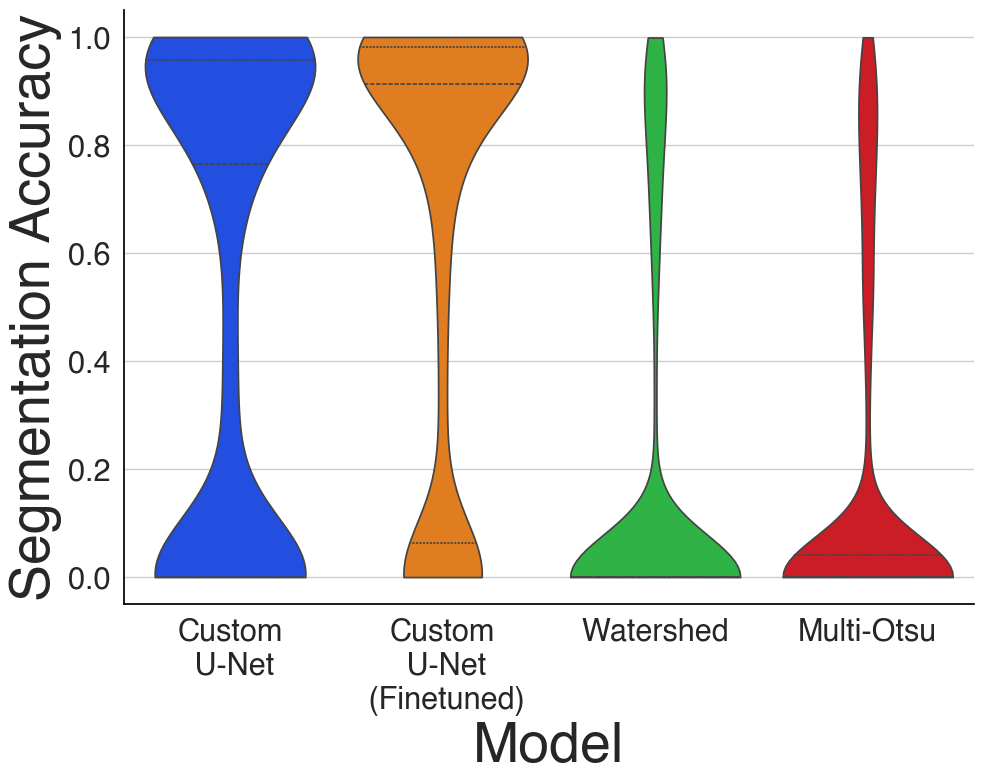

In [146]:
# IMPORTANT: Run this code twice (once with 'standard' and once with 'percentile') to generate all results.
norm_type = 'standard'

if norm_type == 'standard':
    in_folder = f'/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/external_test_set_eval/external_eval_standard/metrics/band_level_accuracy_analysis/'
elif norm_type == 'percentile':
    in_folder = f'/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/external_test_set_eval/external_eval_percentile_norm/metrics/band_level_accuracy_analysis/'

eval_models = ['unet_dec_21', 'unet_dec_21_finetune', 'watershed', 'multiotsu']
image_names = ['20190416 Gel1 Gold A15',
'20190627 A15  Acetate and Phosphate Buffer Heat to 80 deg',
'20190808 A15 Acetate Buffer pH 4 NoUrea during incubation Heat to 80 deg add EDTA',
'20200904 G15 Au Conc pH 4 25 mM NaCl',
'20210113-3 elements-4% agaroase  L R LR LMR from 18nt to 24nt-90V90min',
'20210131-[Cy2]',
'20210802-120min-[Cy2]',
'20211120-2%  agarose 90V 65min ratio test of 250nM and 450nM',
'20211207 ATP blocker test- 5mM ATP on 7 different groups of DX structure 90v90min',
'202008031 G15 pH 4 pH8 25 mM NaCl',
'CB 2022-03-28_18h25m04s',
'CB 2022-04-07_18h15m13sAE',
'CB 2022-05-02_15h17m50s',
'CB 2022-06-03_17h22m08s',
'CB 2023-10-18_18h26m27s',
'Gel_1',
'Gel_2',
'Gel_4',
'Gel_5',
'Gel_7',
'Picture1',
'Picture2',
'Picture3',
'Picture4',
'Picture5']

gel_level_dict = pickle.load(open(os.path.join(in_folder, 'gel_level_stats_no_ceiling.pkl'), 'rb'))
ceiling = False
for dataset_combo, data_name in zip([image_names], ['All Gels (n=25)']):
    dataset_level_full_accuracy_list = defaultdict(list)
    for key, val in gel_level_dict.items():
        if key not in dataset_combo:
            continue
        for model_ind, model in enumerate(eval_models):
            id_list = val['identified'][model_ind]
            accuracy_list = [max(1 - x, 0) for x in val['error'][model_ind]]
            dataset_level_full_accuracy_list[model].extend([max(1 - x, 0) if val['multi_band'][model_ind][ind] is False else 0 for ind, x in enumerate(val['error'][model_ind])])

    full_accuracy_dataset = pd.DataFrame.from_dict(dataset_level_full_accuracy_list)
    full_accuracy_dataset.rename(columns={'unet_dec_21': 'Custom\n U-Net',
                                          'unet_dec_21_finetune': 'Custom\n U-Net\n (Finetuned)',
                                          'watershed': 'Watershed',
                                          'multiotsu': 'Multi-Otsu'}, inplace=True)
    sns.set(style="whitegrid")
    plt.rcParams['font.family'] = 'Helvetica'

    fig, ax = plt.subplots(figsize=(10, 8))

    vplot = sns.violinplot(data=full_accuracy_dataset, cut=0,
                           palette='bright', inner='quartile')

    # Set the color of the spines to black
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.ylabel('Segmentation Accuracy', fontsize=40)
    plt.xlabel('Model', fontsize=40)
    plt.yticks(fontsize=22)
    vplot.tick_params(axis='x', labelsize=22)
    plt.tight_layout()
    plt.show()


In [143]:
# this table is used to populate the supplementary material table
full_accuracy_dataset.describe()

,Custom\n U-Net,Custom\n U-Net\n (Finetuned),Watershed,Multi-Otsu
count,1385.000000,1385.000000,1385.000000,1385.000000
mean,0.573123,0.706207,0.180914,0.176355
std,0.441212,0.399714,0.342593,0.324513
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.445233,0.000000,0.000000
50%,0.828095,0.950305,0.000000,0.000000
75%,0.990667,0.991725,0.000000,0.117550
max,1.000000,1.000000,0.999506,0.998262


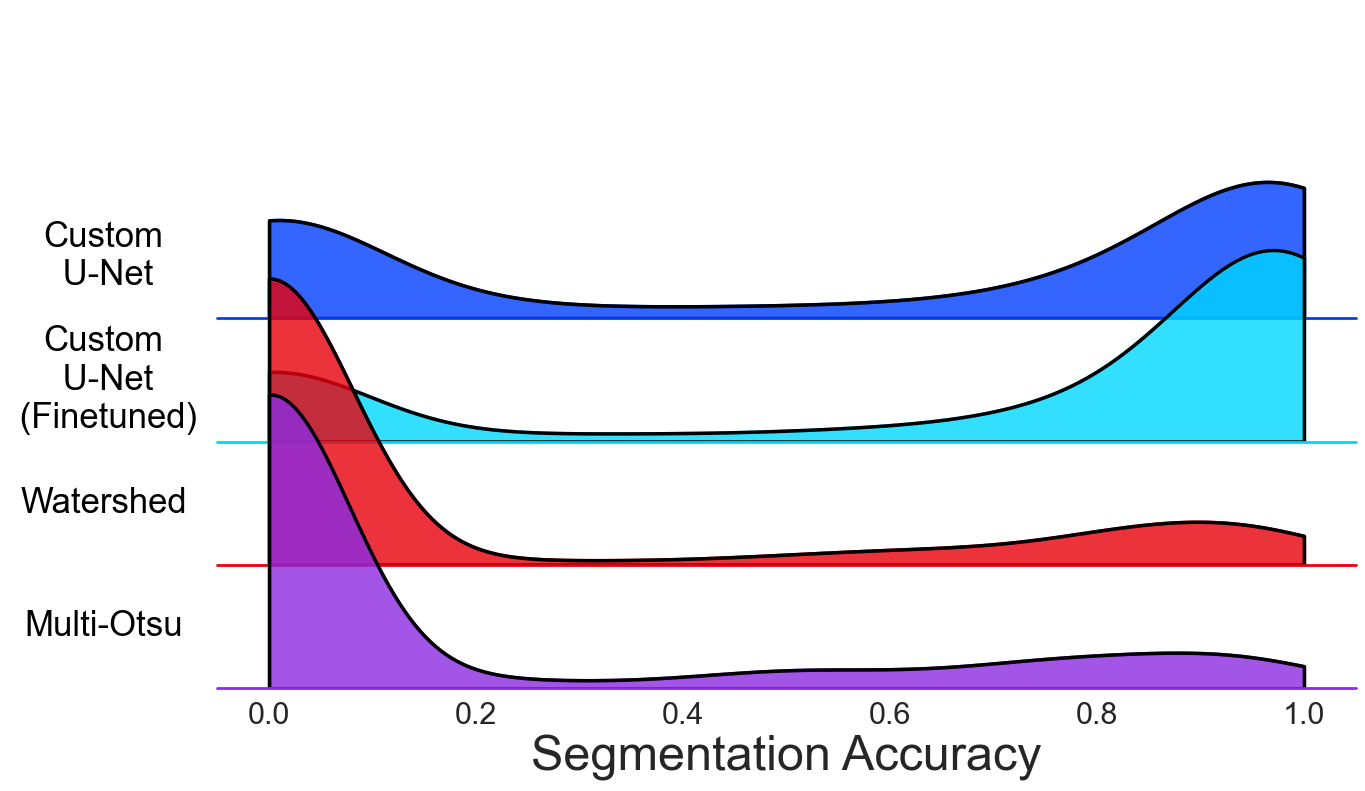

In [144]:
# version 3 of Fig. 3C
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
palette = 'bright'
palette = ['#023eff', '#00d7ff', '#e8000b', '#8b2be2']

g = sns.FacetGrid(pd.melt(full_accuracy_dataset), row= 'variable', hue='variable', palette=palette, aspect=7, height=2)

# Draw the densities in a few steps
g.map(sns.kdeplot, "value", clip=(0,1), fill=True, alpha=0.8, linewidth=2.5)
g.map(sns.kdeplot, "value", clip=(0,1), fill=True, alpha=0, color="black", linewidth=2.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.1, .2, label, color='black', fontsize=25,
            ha="center", va="center", transform=ax.transAxes)

g.map(label, "value")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.6)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True, right=True, top=True)
plt.xlabel('Segmentation Accuracy', fontsize=35)
plt.xticks(fontsize=22)

# plt.tight_layout()
if norm_type == 'percentile':
    plt.savefig('/Users/matt/Desktop/ridge_plot_external_dataset_percentile_norm.pdf', bbox_inches='tight')
else:
    plt.savefig('/Users/matt/Desktop/ridge_plot_external_dataset_standard_norm.pdf', bbox_inches='tight')